In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from Configs import getEnvConfig, visualizeEnvConfig, getPredictorConfig, visualizePredictorConfig
from EnvLibs import PolicySimulator, createEnv
from DiffusionLibs import DiffusionPolicyInterface
from MdpSolverLibs import MdpKernel

In [2]:
configIdx = 0
envParams = getEnvConfig(configIdx)
visualizeEnvConfig(envParams)
predictorParams = getPredictorConfig(configIdx)
visualizePredictorConfig(predictorParams)
trafficDataParentPath = f'Results/TrafficData'
env = createEnv(envParams, trafficDataParentPath)
env.selectMode(mode="test", type="data")

Environment Configuration
Number of Users:        4
Window Length:          200
Dataflow:               thumb_fr
N_aggregation:          4
Resource Bar:           5
Bandwidth:              100
M List:                 [3, 4, 5]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.001
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


In [3]:
num_windows = 1000
obvMode = "perfect" # "perfect" or "predicted"

# ==== Prepare DiffusionQ Policy====
diffusionQParams = {
    'device': 'cuda',
    'gamma': 0.99,
    'tau': 0.005,
    'lr': 5e-4,
    'eta': 1.0,
    'dropout_p': 0.0,
}
diffusionPolicyInterface = DiffusionPolicyInterface(envParams, **diffusionQParams)
model_state_dict = torch.load(f'Results/DiffusionQ/diffusionQ_config{configIdx}.pth')
diffusionPolicyInterface.diffusionQ.load_state_dict(model_state_dict)
diffusionPolicyInterface.diffusionQ.train(True)

In [4]:
model_state_dict, info = diffusionPolicyInterface.trainOnline(
    env, epochs=500, windowPerEpoch=64, obvMode="predicted")

Epoch    0/ 500Avg. Packet Loss: 0.6321  Avg. Ld: 0.0000  Avg. Lq: 0.6337  Avg. loss_critic: 0.5031


Epoch   50/ 500Avg. Packet Loss: 0.7082  Avg. Ld: 0.0000  Avg. Lq: 0.7143  Avg. loss_critic: 0.5869


Epoch  100/ 500Avg. Packet Loss: 0.7518  Avg. Ld: 0.0000  Avg. Lq: 1.5012  Avg. loss_critic: 0.5661


Epoch  150/ 500Avg. Packet Loss: 0.4834  Avg. Ld: 0.0000  Avg. Lq: 1.2437  Avg. loss_critic: 0.5720


Epoch  200/ 500Avg. Packet Loss: 0.3215  Avg. Ld: 0.0000  Avg. Lq: 0.8666  Avg. loss_critic: 0.4932


Epoch  250/ 500Avg. Packet Loss: 0.2902  Avg. Ld: 0.0000  Avg. Lq: 0.7899  Avg. loss_critic: 0.5105


Epoch  300/ 500Avg. Packet Loss: 0.2462  Avg. Ld: 0.0000  Avg. Lq: 0.6976  Avg. loss_critic: 0.5411


Epoch  350/ 500Avg. Packet Loss: 0.2181  Avg. Ld: 0.0000  Avg. Lq: 0.6764  Avg. loss_critic: 0.6322


Epoch 360/500:  22%|██▏       | 14/64 [00:00<00:00, 139.21window/s]                           

In [5]:

torch.save(model_state_dict, f'Results/DiffusionQ/diffusionQ_online_config{configIdx}.pth')
print(f"Model saved to Results/DiffusionQ/diffusionQ_online_config{configIdx}.pth")

Model saved to Results/DiffusionQ/diffusionQ_online_config0.pth


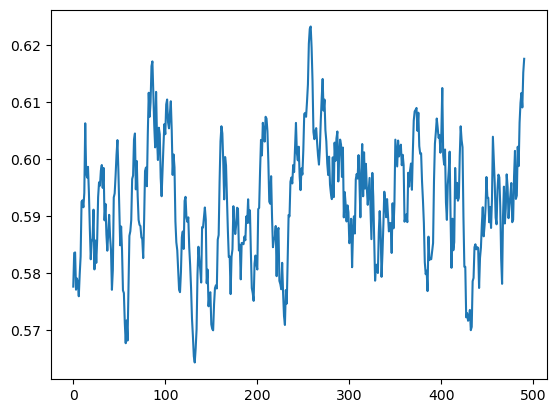

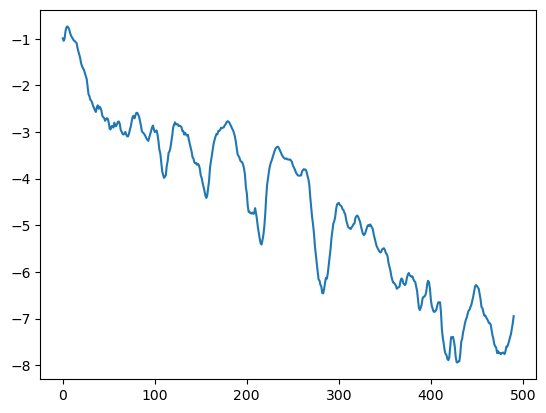

In [6]:
def smooth(x, window_size=10):  
    return np.convolve(x, np.ones(window_size)/window_size, mode='valid')

plt.plot(smooth(info['rewardRecord']))
plt.show()
plt.plot(smooth(info['LqRecord']))
plt.show()